

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns,pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD_google
from covid19model.models.time_dependant_parameter_fncs import google_lockdown, ramp_fun, contact_matrix
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator 
from covid19model.visualization.optimization import plot_fit, traceplot


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load data

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}


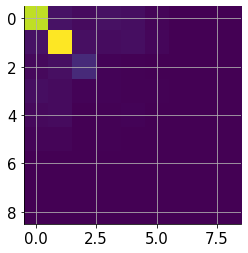

In [53]:
plt.imshow(Nc_schools, cmap='viridis')

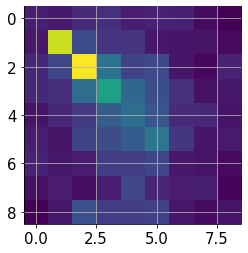

In [18]:
plt.imshow(Nc_leisure, cmap='viridis')

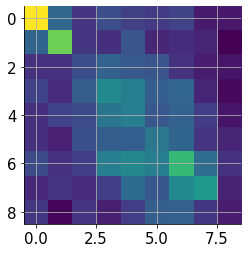

In [19]:
plt.imshow(Nc_others, cmap='viridis')

In [20]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail(2)

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-11-17,6240,1356,372,670,5507,118,0.0,9.0,14,45,50
2020-11-18,5897,1325,353,562,5298,18,0.0,1.0,4,8,5


In [21]:
df_google = google.get_google_mobility_data(update=False, plot=False)
df_google.tail(2)

,retail_recreation,grocery,parks,transport,work,residential
date,,,,,,
2020-11-14,-57.0,-10.0,47.0,-38.0,-22.0,13.0
2020-11-15,-65.0,-20.0,-27.0,-50.0,-23.0,11.0


In [ ]:

# def switch_beta(t,param,samples_dict):
#     if t < pd.to_datetime('2020-05-04'):
#         return np.random.choice(samples_dict['beta'],1,replace=False)
#     elif pd.to_datetime('2020-05-04') < t <= pd.to_datetime('2020-09-01'):
#         return np.random.choice(samples_dict['beta_summer'],1,replace=False)
#     else:
#         return np.random.choice(samples_dict['beta'],1,replace=False)

# Wave 2: September 2020 - present

In [22]:
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)    

In [34]:
# Start of data collection
start_data = '2020-09-01'
# Start data of recalibration ramp
start_calibration = '2020-09-01'
# Last datapoint used to recalibrate the ramp
end_calibration = '2020-11-15'
# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'


## 6 prevention parameters

In [ ]:
# Spatial unit: Belgium
spatial_unit = 'BE_6_prev_full'

In [ ]:
def contact_matrix(t, df_google, Nc_all, prev_home=1, prev_schools=1, prev_work=1, prev_transport=1, prev_leisure=1, prev_others=1, school=None, work=None, transport=None, leisure=None, others=None):
    """
    t : timestamp
        current date
    Nc_all : dictionnary
        contact matrices for home, schools, work, transport, leisure and others
    prev_... : float [0,1]
        prevention parameter to estimate
    school, work, transport, leisure, others : float [0,1]
        level of opening of these sectors
        if None, it is calculated from google mobility data
        only school cannot be None!
    """
    
    if t < pd.Timestamp('2020-03-15'):
        CM = Nc_all['total']
    else:
        
        if school is None:
            raise ValueError(
            "Please indicate to which extend schools are open")
        
        if pd.Timestamp('2020-03-15') < t <= df_google.index[-1]:
            #take t.date() because t can be more than a date! (e.g. when tau_days is added)
            row = -df_google[df_google.index == pd.Timestamp(t.date())]/100 
        else:
            row = -df_google.iloc[[-1],:]/100

        if work is None:
            work=(1-row['work'].values)[0]
        if transport is None:
            transport=(1-row['transport'].values)[0]
        if leisure is None:
            leisure=(1-row['retail_recreation'].values)[0]
        if others is None:
            others=(1-row['grocery'].values)[0]

        CM = (prev_home*(1/2.3)*Nc_all['home'] + 
              prev_schools*school*Nc_all['schools'] + 
              prev_work*work*Nc_all['work'] + 
              prev_transport*transport*Nc_all['transport'] + 
              prev_leisure*leisure*Nc_all['leisure'] + 
              prev_others*others*Nc_all['others']) 


    return CM


In [ ]:
def wave2_policies(t,param,df_google, Nc_all, l , tau, 
                   prev_schools, prev_work, prev_transport, prev_leisure, prev_others, prev_home):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2021-01-04') # schools re-open

    if t5 < t <= t6 + tau_days:
        return contact_matrix(t, df_google, Nc_all, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        policy_old = contact_matrix(t, df_google, Nc_all, school=1)
        policy_new = contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                                    prev_leisure, prev_others, school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    elif t7 < t <= t8:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=1)
    elif t8 < t <= t9:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    else:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=1)



In [ ]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
               'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_transport': 0.5,
               'prev_leisure': 0.5,
               'prev_others': 0.5,
               'prev_home' : 0.5
              })

# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': wave2_policies})

In [ ]:
warmup=0
maxiter = 100
popsize = 100
processes = 32 # voor eraser!!
steps_mcmc = 3000#3000
discard = 1000

# define dataset
data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = [["H_in"]]

####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta','l','tau',
            'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home']
bounds=((1,2000),(0.010,0.060),(0.1,20),(0.1,20),
        (0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

# run PSO optimisation
theta = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
                    start_date=start_calibration,warmup=warmup, processes=processes) ## PROCESSES=1 to debug!

# run MCMC sampler
print('\n2) Markov-Chain Monte-Carlo sampling\n')
parNames_mcmc = parNames
bounds_mcmc=((1,2000),(0.020,0.060),(0.001,20),(0.001,20),
             (0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

ndim = len(theta)
nwalkers = ndim*2
perturbations = ([1]+(ndim-1)*[1e-3]) * np.random.randn(nwalkers, ndim)
pos = theta + perturbations

sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                    args=(model, bounds_mcmc, data, states, parNames_mcmc, None, start_calibration, warmup))
sampler.run_mcmc(pos, steps_mcmc, progress=True)

try:
    sampler.get_autocorr_time()
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s).\nUse this estimate with caution and run a longer chain!')
from covid19model.optimization.run_optimization import checkplots
checkplots(sampler, discard, fig_path, spatial_unit, figname='BETA_RAMP_GOOGLE_WAVE2', 
           labels=['$\sigma_{data}$','$\\beta$','l','$\\tau$',
                   'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home'])

#############################################
####### Output to dictionary ################
#############################################

samples_dict_wave2 = {
    'sigma_data' : sampler.get_chain(discard=discard,flat=True)[:,0].tolist(),
    'beta': sampler.get_chain(discard=discard,flat=True)[:,1].tolist(),
    'l' : sampler.get_chain(discard=discard,flat=True)[:,2].tolist(),
    'tau' : sampler.get_chain(discard=discard,flat=True)[:,3].tolist(),
    'prev_schools': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_work': sampler.get_chain(discard=discard,flat=True)[:,5].tolist(),
    'prev_transport': sampler.get_chain(discard=discard,flat=True)[:,6].tolist(),
    'prev_leisure': sampler.get_chain(discard=discard,flat=True)[:,7].tolist(),
    'prev_others': sampler.get_chain(discard=discard,flat=True)[:,8].tolist(),
    'prev_home': sampler.get_chain(discard=discard,flat=True)[:,9].tolist(),
    'calibration_data' : states[0][0],
    'start_date' : start_calibration,
    'end_date' : end_calibration,
    'maxiter' : maxiter,
    'popsize': popsize,
    'steps_mcmc': steps_mcmc,
    'discard' : discard,

}

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'_WAVE2_GOOGLE.json', 'w') as fp:
    json.dump(samples_dict_wave2, fp)

In [ ]:
fig,ax = plt.subplots()
plt.hist(samples_dict_wave2['prev_schools'])

In [ ]:
end_sim = '2021-01-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    # Sampling
    idx, model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave2['beta'])))
    model.parameters['l'] = samples_dict_wave2['l'][idx] 
    model.parameters['tau'] = samples_dict_wave2['tau'][idx]    
    model.parameters['prev_schools'] = samples_dict_wave2['prev_schools'][idx]    
    model.parameters['prev_work'] = samples_dict_wave2['prev_work'][idx]     
    model.parameters['prev_transport'] = samples_dict_wave2['prev_transport'][idx]    
    model.parameters['prev_leisure'] = samples_dict_wave2['prev_leisure'][idx]     
    model.parameters['prev_others'] = samples_dict_wave2['prev_others'][idx]      

    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,warmup=0)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.05)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
fig.savefig(fig_path+'others/FIT_WAVE2_GOOGLE_'+spatial_unit+'_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')

## 4 prevention parameters

In [43]:
# Spatial unit: Belgium
spatial_unit = 'BE_4_prev_full'

In [36]:
def contact_matrix(t, df_google, Nc_all, prev_home=1, prev_schools=1, prev_work=1, prev_rest=1, school=None, work=None, transport=None, leisure=None, others=None):
    """
    t : timestamp
        current date
    Nc_all : dictionnary
        contact matrices for home, schools, work, transport, leisure and others
    prev_... : float [0,1]
        prevention parameter to estimate (rest = transport, leisure, others)
    school, work, transport, leisure, others : float [0,1]
        level of opening of these sectors
        if None, it is calculated from google mobility data
        only school cannot be None!
    """
    
    if t < pd.Timestamp('2020-03-15'):
        CM = Nc_all['total']
    else:
        
        if school is None:
            raise ValueError(
            "Please indicate to which extend schools are open")
        
        if pd.Timestamp('2020-03-15') < t <= df_google.index[-1]:
            #take t.date() because t can be more than a date! (e.g. when tau_days is added)
            row = -df_google[df_google.index == pd.Timestamp(t.date())]/100 
        else:
            row = -df_google.iloc[[-1],:]/100

        if work is None:
            work=(1-row['work'].values)[0]
        if transport is None:
            transport=(1-row['transport'].values)[0]
        if leisure is None:
            leisure=(1-row['retail_recreation'].values)[0]
        if others is None:
            others=(1-row['grocery'].values)[0]

        CM = (prev_home*(1/2.3)*Nc_all['home'] + 
              prev_schools*school*Nc_all['schools'] + 
              prev_work*work*Nc_all['work'] + 
              prev_rest*transport*Nc_all['transport'] + 
              prev_rest*leisure*Nc_all['leisure'] + 
              prev_rest*others*Nc_all['others']) 


    return CM


In [37]:
def wave2_policies(t,param,df_google, Nc_all, l , tau, 
                   prev_schools, prev_work, prev_rest, prev_home):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2021-01-04') # schools re-open

    if t5 < t <= t6 + tau_days:
        return contact_matrix(t, df_google, Nc_all, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        policy_old = contact_matrix(t, df_google, Nc_all, school=1)
        policy_new = contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t8 < t <= t9:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    else:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)



In [38]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
               'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_rest': 0.5,
               'prev_home' : 0.5
              })

# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': wave2_policies})

In [44]:
warmup=0
maxiter = 100
popsize = 100
processes = 32 # voor eraser!!
steps_mcmc = 3000#3000
discard = 1000#1000

# define dataset
data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = [["H_in"]]

------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-09-01 until 2020-11-15

1) Particle swarm optimization

No constraints given.
New best for swarm at iteration 1: [2.17210443e+02 2.60289688e-02 3.69431347e+00 1.51396468e+01
 9.38968355e-01 1.00000000e+00 4.96176238e-01 6.56084849e-01] 424.2763804580605
Best after iteration 1: [2.17210443e+02 2.60289688e-02 3.69431347e+00 1.51396468e+01
 9.38968355e-01 1.00000000e+00 4.96176238e-01 6.56084849e-01] 424.2763804580605
New best for swarm at iteration 2: [9.99278408e+01 2.80803792e-02 1.00000000e-01 1.00000000e-01
 1.00000000e+00 0.00000000e+00 5.51598447e-01 7.86193896e-01] 397.65368850425443
Best after iteration 2: [9.99278408e+01 2.80803792e-02 1.00000000e-01 1.00000000e-01
 1.00000000e+00 0.00000000e+00 5.51598447e-01 7.86193896e-01] 397.65368850425443
Best after iteration 3: [9.99278408e+01 2.80803792e-02 1.00000000e-01 1.00000000e-01
 1.00000000e+00 0.00

Best after iteration 35: [5.65891663e+01 2.77370451e-02 4.44870942e+00 1.19536203e+00
 9.99982322e-01 1.01630576e-03 8.37487098e-01 7.20686268e-01] 343.755065304693
Best after iteration 36: [5.65891663e+01 2.77370451e-02 4.44870942e+00 1.19536203e+00
 9.99982322e-01 1.01630576e-03 8.37487098e-01 7.20686268e-01] 343.755065304693
Best after iteration 37: [5.65891663e+01 2.77370451e-02 4.44870942e+00 1.19536203e+00
 9.99982322e-01 1.01630576e-03 8.37487098e-01 7.20686268e-01] 343.755065304693
New best for swarm at iteration 38: [5.71734664e+01 2.78355429e-02 4.30417839e+00 1.31140145e+00
 1.00000000e+00 3.89319367e-04 8.37081757e-01 6.59546964e-01] 343.57648822446185
Best after iteration 38: [5.71734664e+01 2.78355429e-02 4.30417839e+00 1.31140145e+00
 1.00000000e+00 3.89319367e-04 8.37081757e-01 6.59546964e-01] 343.57648822446185
Best after iteration 39: [5.71734664e+01 2.78355429e-02 4.30417839e+00 1.31140145e+00
 1.00000000e+00 3.89319367e-04 8.37081757e-01 6.59546964e-01] 343.57648822

New best for swarm at iteration 66: [5.32773160e+01 2.77554930e-02 5.77503424e+00 1.44143058e+00
 1.00000000e+00 0.00000000e+00 7.81728817e-01 3.76166285e-01] 341.94076543545185
Best after iteration 66: [5.32773160e+01 2.77554930e-02 5.77503424e+00 1.44143058e+00
 1.00000000e+00 0.00000000e+00 7.81728817e-01 3.76166285e-01] 341.94076543545185
Best after iteration 67: [5.32773160e+01 2.77554930e-02 5.77503424e+00 1.44143058e+00
 1.00000000e+00 0.00000000e+00 7.81728817e-01 3.76166285e-01] 341.94076543545185
New best for swarm at iteration 68: [5.39755488e+01 2.77558747e-02 5.77378424e+00 1.43595634e+00
 1.00000000e+00 0.00000000e+00 7.75141435e-01 4.08251108e-01] 341.9318075210798
Best after iteration 68: [5.39755488e+01 2.77558747e-02 5.77378424e+00 1.43595634e+00
 1.00000000e+00 0.00000000e+00 7.75141435e-01 4.08251108e-01] 341.9318075210798
New best for swarm at iteration 69: [5.41715061e+01 2.77652425e-02 5.83378479e+00 1.46712183e+00
 1.00000000e+00 0.00000000e+00 7.82275327e-01 3.

Best after iteration 96: [5.41416733e+01 2.77009646e-02 6.56716544e+00 1.89710363e+00
 1.00000000e+00 0.00000000e+00 7.24408890e-01 0.00000000e+00] 341.3371493779
Best after iteration 97: [5.41416733e+01 2.77009646e-02 6.56716544e+00 1.89710363e+00
 1.00000000e+00 0.00000000e+00 7.24408890e-01 0.00000000e+00] 341.3371493779
Best after iteration 98: [5.41416733e+01 2.77009646e-02 6.56716544e+00 1.89710363e+00
 1.00000000e+00 0.00000000e+00 7.24408890e-01 0.00000000e+00] 341.3371493779
Best after iteration 99: [5.41416733e+01 2.77009646e-02 6.56716544e+00 1.89710363e+00
 1.00000000e+00 0.00000000e+00 7.24408890e-01 0.00000000e+00] 341.3371493779
Best after iteration 100: [5.41416733e+01 2.77009646e-02 6.56716544e+00 1.89710363e+00
 1.00000000e+00 0.00000000e+00 7.24408890e-01 0.00000000e+00] 341.3371493779
Stopping search: maximum iterations reached --> 100

2) Markov-Chain Monte-Carlo sampling



  0%|          | 0/50 [00:00<?, ?it/s]/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50/50 [02:10<00:00,  2.60s/it]
/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


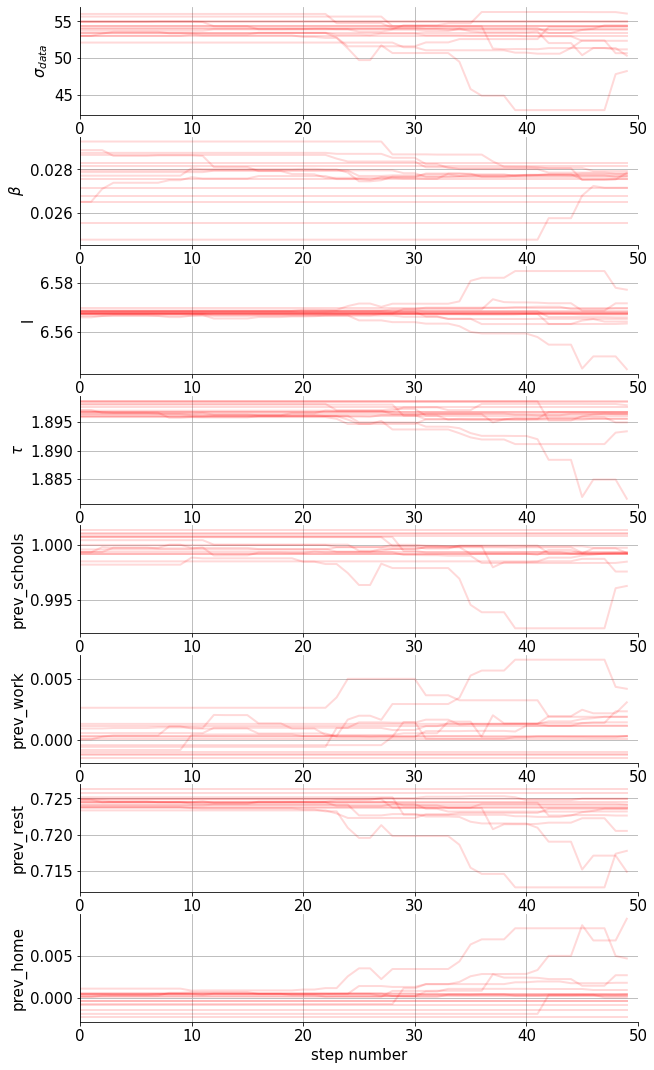

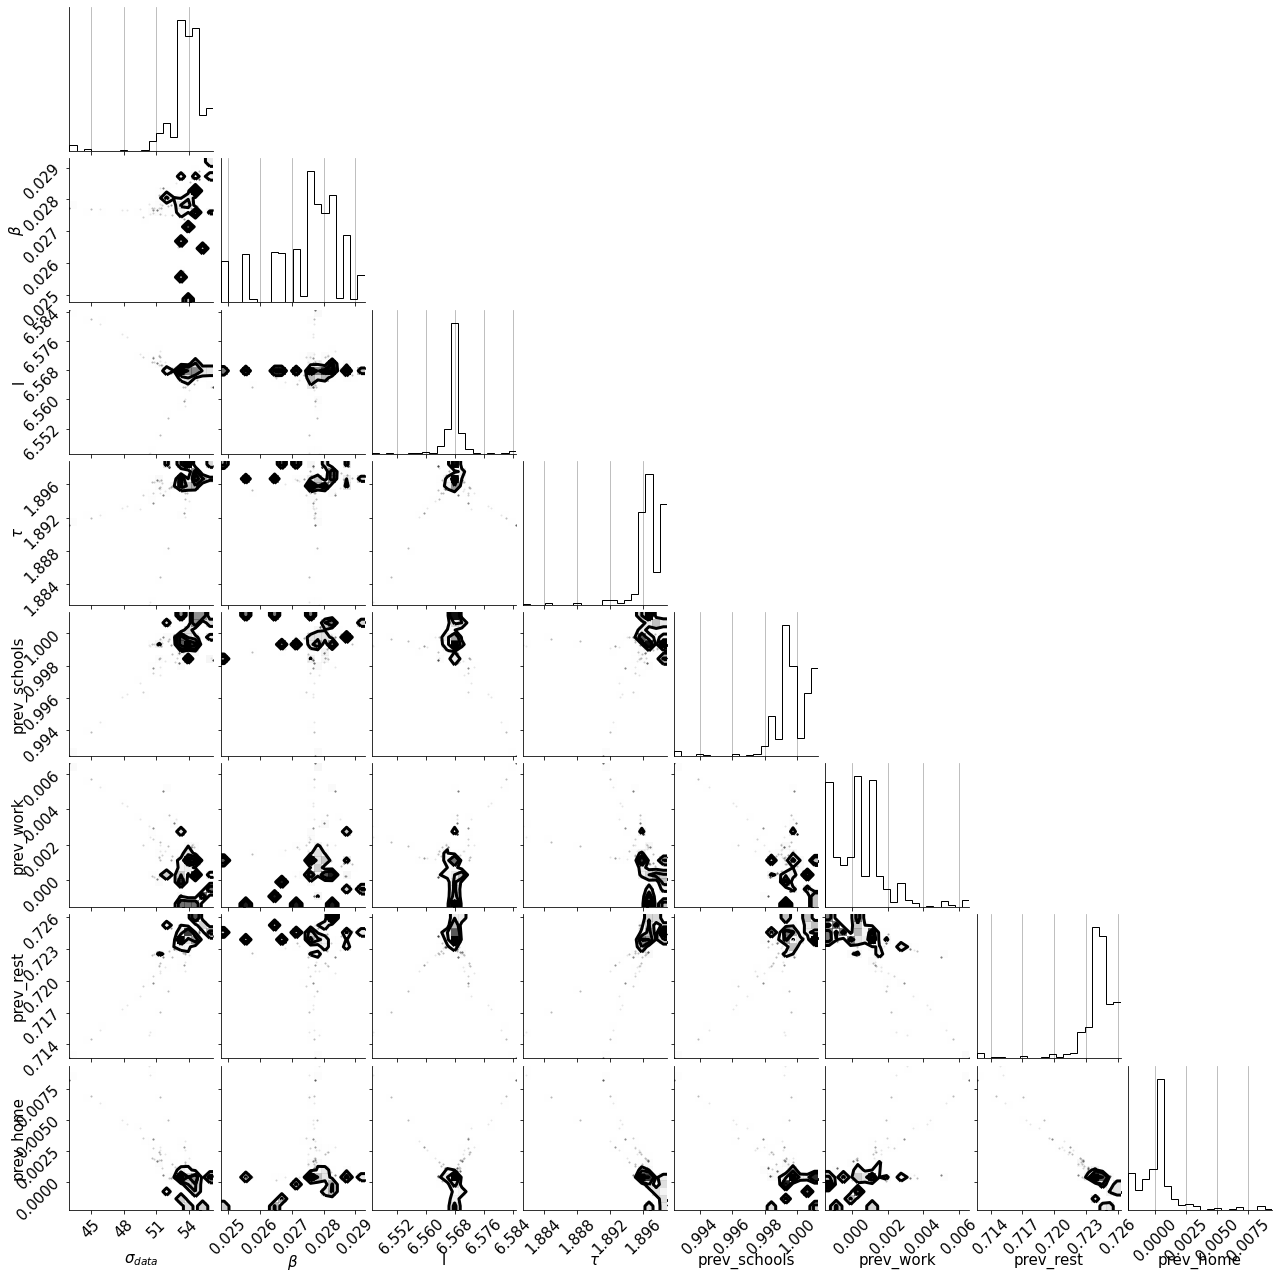

In [39]:
####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta','l','tau',
            'prev_schools', 'prev_work', 'prev_rest', 'prev_home']
bounds=((1,2000),(0.010,0.060),(0.1,20),(0.1,20),
        (0,1),(0,1),(0,1),(0,1))

# run PSO optimisation
theta = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
                    start_date=start_calibration,warmup=warmup, processes=processes) ## PROCESSES=1 to debug!




2) Markov-Chain Monte-Carlo sampling



  0%|          | 0/3000 [00:00<?, ?it/s]/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [5:01:09<00:00,  6.02s/it]  


Use this estimate with caution and run a longer chain!


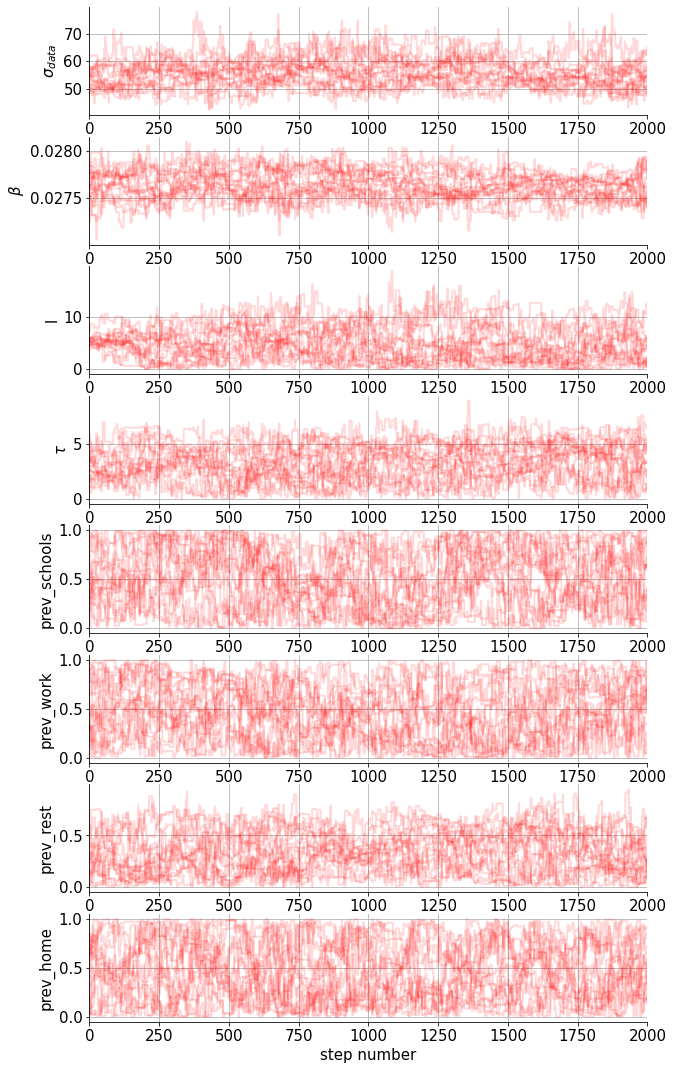

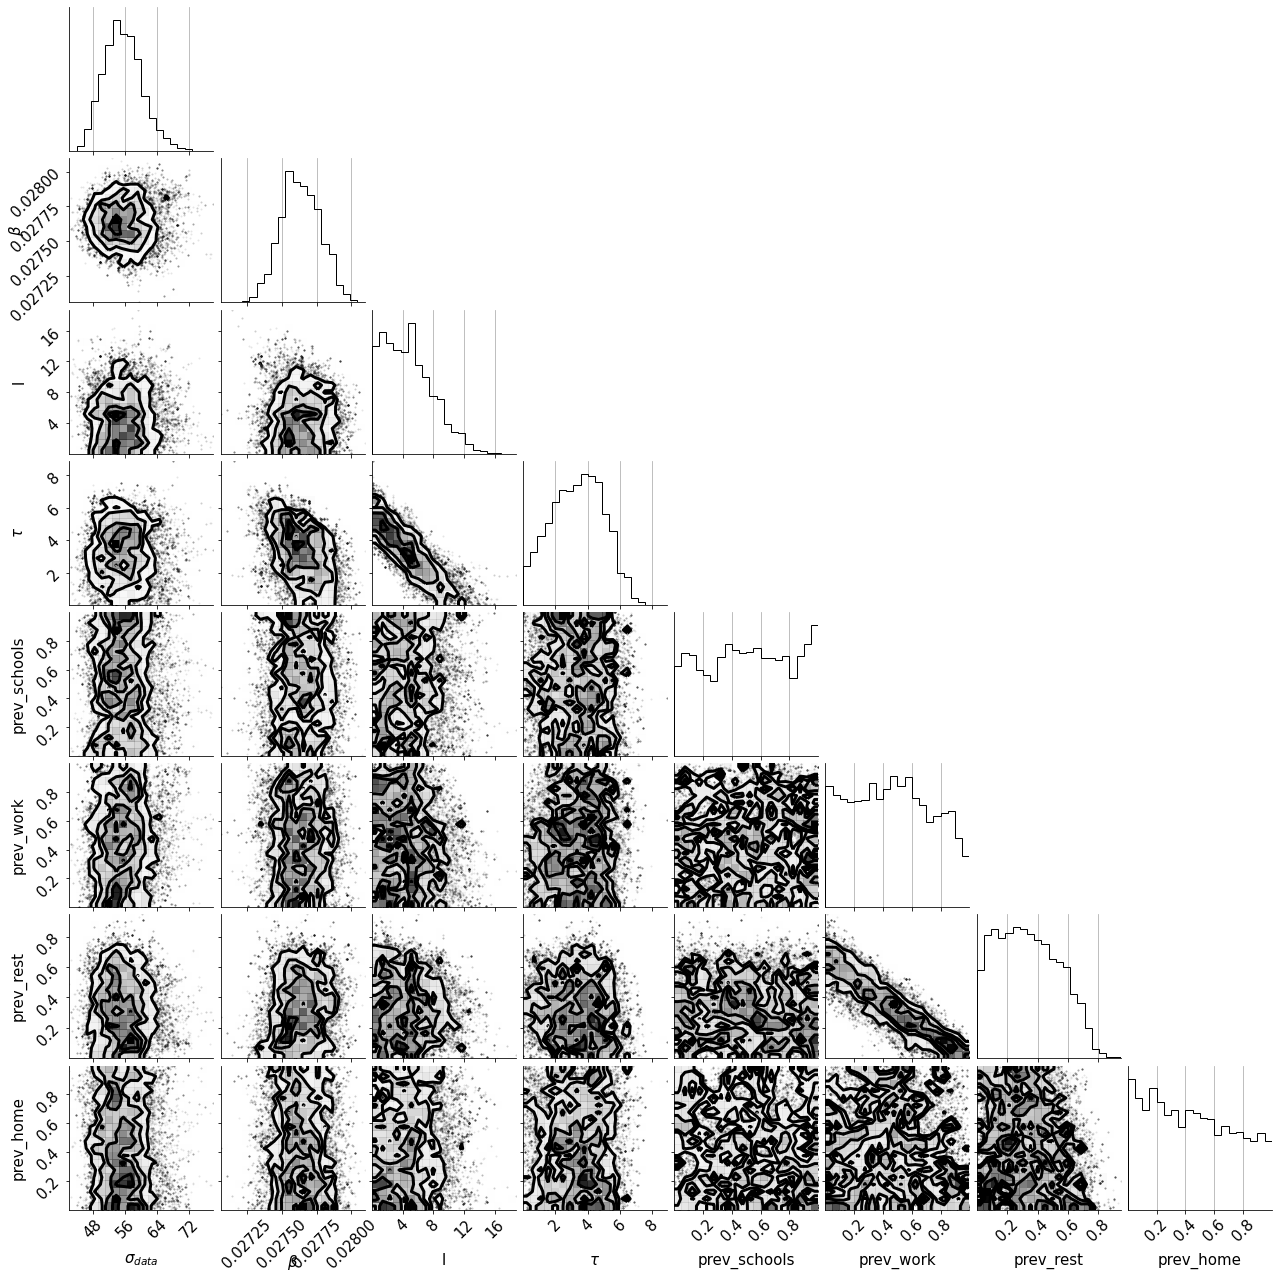

In [45]:
# run MCMC sampler
print('\n2) Markov-Chain Monte-Carlo sampling\n')
parNames_mcmc = parNames
bounds_mcmc=((1,2000),(0.020,0.060),(0.001,20),(0.001,20),
             (0,1),(0,1),(0,1),(0,1))

ndim = len(theta)
nwalkers = ndim*2
perturbations = ([1]+(ndim-1)*[1e-3]) * np.random.randn(nwalkers, ndim)
pos = theta + perturbations

sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                    args=(model, bounds_mcmc, data, states, parNames_mcmc, None, start_calibration, warmup))
sampler.run_mcmc(pos, steps_mcmc, progress=True)

try:
    sampler.get_autocorr_time()
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s).\nUse this estimate with caution and run a longer chain!')
from covid19model.optimization.run_optimization import checkplots
checkplots(sampler, discard, fig_path, spatial_unit, figname='BETA_RAMP_GOOGLE_WAVE2', 
           labels=['$\sigma_{data}$','$\\beta$','l','$\\tau$',
                   'prev_schools', 'prev_work', 'prev_rest', 'prev_home'])

#############################################
####### Output to dictionary ################
#############################################

samples_dict_wave2 = {
    'sigma_data' : sampler.get_chain(discard=discard,flat=True)[:,0].tolist(),
    'beta': sampler.get_chain(discard=discard,flat=True)[:,1].tolist(),
    'l' : sampler.get_chain(discard=discard,flat=True)[:,2].tolist(),
    'tau' : sampler.get_chain(discard=discard,flat=True)[:,3].tolist(),
    'prev_schools': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_work': sampler.get_chain(discard=discard,flat=True)[:,5].tolist(),
    'prev_rest': sampler.get_chain(discard=discard,flat=True)[:,6].tolist(),
    'prev_home': sampler.get_chain(discard=discard,flat=True)[:,7].tolist(),
    'calibration_data' : states[0][0],
    'start_date' : start_calibration,
    'end_date' : end_calibration,
    'maxiter' : maxiter,
    'popsize': popsize,
    'steps_mcmc': steps_mcmc,
    'discard' : discard,

}

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'_WAVE2_GOOGLE.json', 'w') as fp:
    json.dump(samples_dict_wave2, fp)

(array([4079., 4819., 4939., 4897., 4492., 3772., 3006., 1655.,  282.,
          59.]),
 array([2.38775492e-04, 9.47537825e-02, 1.89268790e-01, 2.83783797e-01,
        3.78298804e-01, 4.72813811e-01, 5.67328818e-01, 6.61843825e-01,
        7.56358832e-01, 8.50873839e-01, 9.45388846e-01]),
 <BarContainer object of 10 artists>)

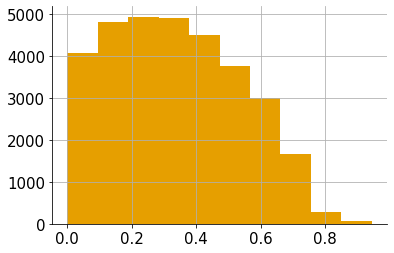

In [48]:
fig,ax = plt.subplots()
plt.hist(samples_dict_wave2['prev_rest'])

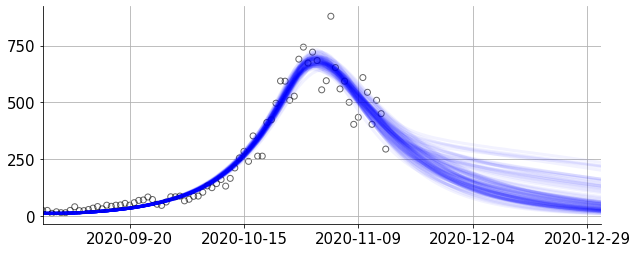

In [49]:
end_sim = '2021-01-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    # Sampling
    idx, model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave2['beta'])))
    model.parameters['l'] = samples_dict_wave2['l'][idx] 
    model.parameters['tau'] = samples_dict_wave2['tau'][idx]    
    model.parameters['prev_schools'] = samples_dict_wave2['prev_schools'][idx]    
    model.parameters['prev_work'] = samples_dict_wave2['prev_work'][idx]       
    model.parameters['prev_rest'] = samples_dict_wave2['prev_rest'][idx]      

    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,warmup=0)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.05)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
fig.savefig(fig_path+'others/FIT_WAVE2_GOOGLE_'+spatial_unit+'_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')